In [2]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *

### Gauss-Legendre grid and Stokes Dirichlet Solver
Define the problem 

### Testing the grid.

We define a grid and sequentially refine it to investigate improvement in accuracy.
Each refinement doubles the number of gridpoints.

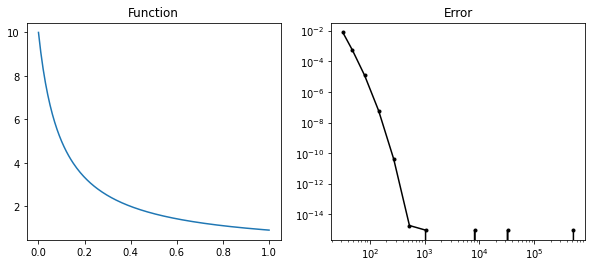

In [3]:
grid = GaussLegGrid(segments=[0,10.])
#Func = lambda t: np.exp(-(t-np.pi)**2)
#func = lambda t: -2*(t-np.pi)*Func(t)
Func = lambda t: np.log(t+0.1) #+  np.log(1.1-t)
func = lambda t: 1/(t+0.1) #- 1/(1.1-t)

true = Func(10) - Func(0)

ns = []
er = []

for i in range(16):
    ns.append(len(grid.segments) * 16)
    er.append(np.abs(grid.integrate(func) - true))
    grid.refine_all_nply(1)
    
t = np.linspace(0,1,200)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Function")
plt.plot(t, func(t))

plt.subplot(1,2,2)
plt.title("Error")
plt.loglog(ns, er, 'k.-')

### Testing solve()
We test convergence of `solve()`. It should be spectral.

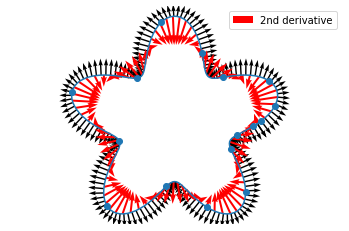

In [4]:
choice = 4 # 1: circle, 2: triangle, 3: rounded square param(t) = exp(1i t)/||exp(1i t)||_P , P > 2.
func = lambda t: np.ones(t.shape, dtype=np.complex128)
    
if choice==1:
    # Boundary parameterisation, circle
    param = lambda t: np.exp(1j * t)
    dparam = lambda t: np.exp(1j * t) * (1j)
    ddparam = lambda t: np.exp(1j * t) * (1j) ** 2
    params = [param, dparam, ddparam]
    segments = np.array([0,2*np.pi])

elif choice==2:
    # Triangle
    ones = lambda t: np.ones(t.shape, dtype=np.complex128)
    param1 = lambda t: (t-0.5)*2.
    dparam1 = lambda t: ones(t)*2.
    ddparam1 = lambda t: ones(t)*0

    param2 = lambda t: (2. - t) + 1j * (t - 1.)
    dparam2 = lambda t: ones(t) * (-1 + 1j)
    ddparam2 = lambda t: ones(t) * 0

    param3 = lambda t: (2. - t) + 1j * (3. - t)
    dparam3 = lambda t: ones(t)*(-1 - 1j)
    ddparam3 = lambda t: ones(t)*0

    domains = np.array([0.,1.,2.,3.])
    param = GaussLegGeometry.stitch_functions([param1,param2,param3], domains)
    dparam = GaussLegGeometry.stitch_functions([dparam1,dparam2,dparam3], domains)
    ddparam = GaussLegGeometry.stitch_functions([ddparam1,ddparam2,ddparam3], domains)
    params = [param, dparam, ddparam]
    segments = domains

elif choice==3:
# rounded Square 
    p = 4.5
    norm = lambda t: (np.abs(np.cos(t))**p + np.abs(np.sin(t))**p)**(1/p)
    dnorm = lambda t: norm(t)**(1-p) * np.sin(t)*np.cos(t)*(np.abs(np.sin(t))**(p-2) - np.abs(np.cos(t))**(p-2))
    def ddnorm(t):
        cost = np.cos(t)
        sint = np.sin(t)
        acost = np.abs(cost)
        asint = np.abs(sint)

        normt = norm(t)
        dnormt = dnorm(t)

        rest = (asint ** (p-2) - acost ** (p-2))
        drest = (cost**2-sint**2)*rest + \
                (sint*cost)**2 *(p-2)* (acost**(p-4) + asint**(p-4))


        return dnormt * (1-p) * normt ** (-p) * rest*sint*cost + \
                        normt ** (1-p) * drest    

    param = lambda t: np.exp(1j* t) / norm(t)
    dparam = lambda t: np.exp(1j*t)*(1j/norm(t) - dnorm(t)/norm(t)**2)
    ddparam = lambda t: 1j * dparam(t) + np.exp(1j*t)*(-1j/norm(t)**2*dnorm(t) - ddnorm(t)/norm(t)**2 + 2*dnorm(t)**2/norm(t)**3)
    params=[param, dparam, ddparam]
    segments = np.array([0, 2*np.pi])

elif choice == 4:
    k = 5
    s = 0.3
    param = lambda t: np.exp(1j * t) * (1 + s * np.sin(k * t))
    dparam = lambda t: np.exp(1j * t) * (1j*(1 + s * np.sin(k * t)) + k*s*np.cos(k * t))
    ddparam = lambda t: np.exp(1j * t) * (-(1 + s * np.sin(k * t)) + 2j * k*s * np.cos(k * t) -k**2 * s*np.sin(k * t))
    params = [param, dparam, ddparam]
    segments = np.array([0, 2*np.pi])

grid = GaussLegGrid(segments=segments, corners=None)
geom = GaussLegGeometry(param=params,grid=grid)
geom.plot(ax=plt.gca(), showpts=True, shownormals=True)

if True:
    t = np.linspace(0,2*np.pi, 100)
    z = param(t)
    x,y = np.real(z), np.imag(z)
    ddz = ddparam(t)
    ddx, ddy = np.real(ddz), np.imag(ddz)
    plt.quiver(x,y,ddx,ddy, color='red', label="2nd derivative")
    

plt.axis("equal")
remove_axes(plt.gca())
plt.legend()

Define a simple boundary problem on a circle. We want to examine the smoothness of the solution.

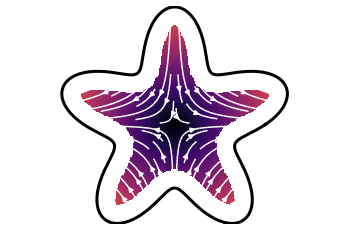

In [5]:
# Boundary condition (uniform in x-direction)
#sol = lambda z: 0*np.ones_like(z) + np.conjugate(z)
sol = lambda z: np.conjugate(z)
condition = lambda t: sol(params[0](t))#+ (1+1j)*np.ones(t.shape, dtype=np.complex128)

grid = GaussLegGrid(segments = np.array([0., 2*np.pi]), corners=None)
grid.refine_all_nply(3)
geom = GaussLegGeometry(param=params,grid=grid)

problem = StokesDirichletProblem(condition=condition, geometry=geom)
problem.condition=condition
problem.solve(tol=1e-10)

plt.figure()
problem.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem.evaluate(z)), \
                            apply_mask=True, masktol=0.1, eps=-0.2, cmap='inferno', vmax=2)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
problem.geometry.plot(ax=plt.gca(), color="black", linewidth=3)
plt.axis("equal")
remove_axes(plt.gca())

None

Let's check convergence by looking at the error in a single point for the given field $u(z) = \overline{z}$.

0: sol with 2 panels done, err=0.5177153681127765
1: sol with 12 panels done, err=4.761589123650271e-06
2: sol with 22 panels done, err=1.4076027744872016e-10
3: sol with 32 panels done, err=2.6313772874466227e-12
4: sol with 42 panels done, err=5.31599203316299e-12
5: sol with 52 panels done, err=6.0821647586984576e-12
6: sol with 62 panels done, err=2.5865508557376032e-12
7: sol with 72 panels done, err=3.616263461507632e-12
8: sol with 82 panels done, err=4.180310454177514e-12
9: sol with 92 panels done, err=4.453527485622935e-12


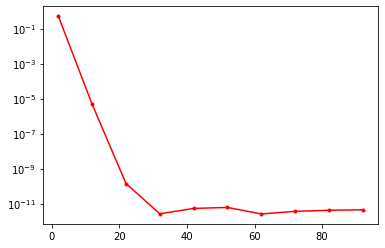

In [6]:
npans = list(range(2,100,10))
errors = []
z_eval = np.array([0.1])

for i in range(len(npans)):
    grid = GaussLegGrid(segments = np.linspace(0., 2*np.pi, npans[i]), corners=None)
    geom = GaussLegGeometry(params, grid)
    problem = StokesDirichletProblem(condition=condition, geometry=geom)
    problem.condition=condition
    problem.solve(tol=1e-10)
    #errors.append(np.abs(problem.evaluate(z_eval) - sol(z_eval).flatten()))
    errors.append(geom.integrate_vol(lambda z: np.abs(problem.evaluate(z) - sol(z).flatten())**2, npts=20, tol=0.001, eps=-0.2)**.5)
    print(f"{i}: sol with {npans[i]} panels done, err={errors[-1]}")
    

#problem.plot(ax=plt.gca())
plt.plot(npans, errors, 'r.-')
plt.yscale("log")

[2.79280893 0.31972764 0.11407196 ... 1.         1.         1.        ]


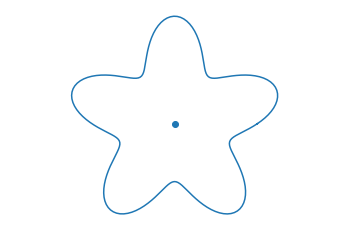

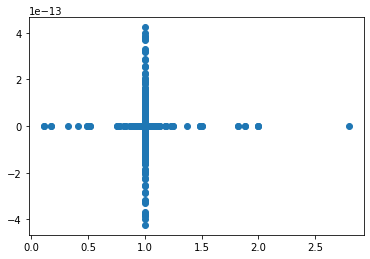

In [7]:
a = geom.get_inner_pt()
geom.plot(plt.gca())
plt.scatter(np.real(a), np.imag(a))

plt.axis("equal")
remove_axes(plt.gca())


plt.figure()
K = geom.stokes_matrix()
eig, _ = np.linalg.eig(K)
plt.scatter(np.real(eig), np.imag(eig))

print(np.abs(eig))

[[-3.66651181e-17]
 [-1.92625245e-16]
 [-4.68114452e-16]
 ...
 [ 1.02549479e-13]
 [ 1.01593159e-13]
 [ 1.01454706e-13]]


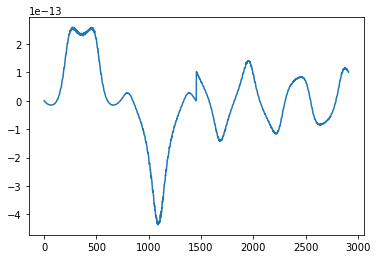

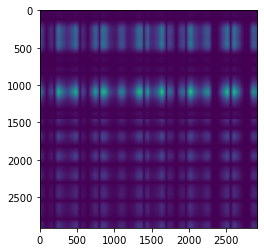

In [8]:
problem.condition = lambda t: np.conjugate(geom.eval_param(derivative=0)) + 0.*geom.eval_param(derivative=1)/1j
problem.solve()

C = geom.stokes_correction_matrix()
out = C @ np.vstack([np.real(problem.density)[:,None], np.imag(problem.density)[:,None]])
plt.plot(out)

print(out)

z = geom.get_inner_pt()
t = geom.eval_param()
dt = geom.eval_param(derivative=1)
w = problem.density

integrand = lambda s: np.real(problem.density /(t - z)**2 * dt)
#integrand = lambda s: np.real(np.conjugate(problem.density) * dt/1j)
geom.grid.integrate(integrand)

plt.figure()
plt.imshow(np.abs(C))
